In [1]:
# Libraries
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py


# Custom functions
import sys
sys.path.append("../src")
from processing import load_zip, apply_scaling

# Global variables
node = 200 # This was a good example

ka_path = '../data/raw/ka.zip'
ismn_path = '../data/processed/ISMN_dataset.h5'
nodeinfo_path = '../data/processed/node_info.csv'


In [2]:
# Load the nodeinfo dataframe and select for the node 

df = pd.read_csv(nodeinfo_path)
df.columns
node_lat, node_lon = df[df['nodeid'] == node]['node_latitude'].values[0], df[df['nodeid'] == node]['node_longitude'].values[0]
node_lat, node_lon

(67.25729, 26.74857)

In [3]:
# Load the ka.zip, select for a given longitude and latitude 

xarray_dataset = load_zip(ka_path)
scaled_xarray = apply_scaling(xarray_dataset)

Loading zipfile from ../data/raw/ka.zip


100%|██████████| 754/754 [00:17<00:00, 42.48it/s]


Applying scaling


100%|██████████| 3/3 [00:10<00:00,  3.39s/it]


In [4]:
# filtered_xarray = scaled_xarray.where(scaled_xarray.lon == node_lon).where(scaled_xarray.lat == node_lat)
""" 
    I need to take the closest value to the actual lat-lon corrdinates. Luckily Xarray has a function to do that with dimensions
"""

node_data = scaled_xarray.sel({"lat" : node_lat, "lon" : node_lon}, method= "nearest")

In [5]:
node_data

<xarray.Dataset>
Dimensions:                     (time: 730)
Coordinates:
    lon                         float32 26.84
    lat                         float32 67.31
  * time                        (time) datetime64[ns] 2017-01-01 ... 2017-12-31
    Pass                        (time) <U10 'Ascending' ... 'Descending'
Data variables:
    Brightness Temperature (H)  (time) float32 217.8 217.8 217.0 ... 238.0 241.0
    Brightness Temperature (V)  (time) float32 230.8 230.6 229.6 ... 247.6 249.3
    Time Information            (time) float32 -145.0 -538.0 ... -601.0 68.0
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

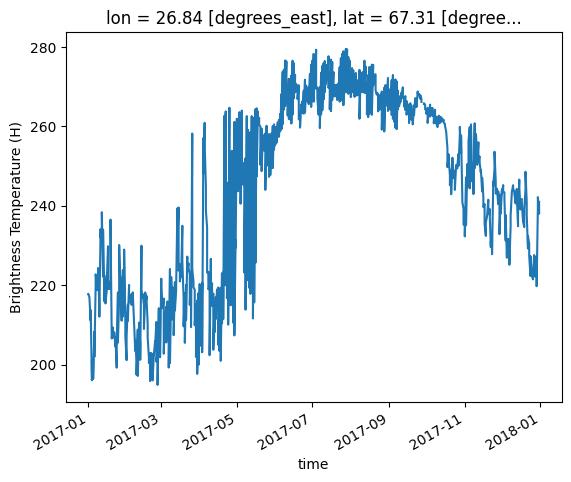

In [6]:
node_data["Brightness Temperature (H)"].plot()

In [7]:
# Let's compare it with the values from the ISMN
ISMN_dataset = xr.open_dataset(ismn_path)
ISMN_dataset

<xarray.Dataset>
Dimensions:       (Node_name: 1369, Register: 96432)
Coordinates:
  * Node_name     (Node_name) object 'ARM\\Anthony' ... 'WSMN\\WSMN-2'
  * Register      (Register) int64 0 1 2 3 4 5 ... 96427 96428 96429 96430 96431
Data variables:
    values        (Node_name, Register) float64 ...
    quality_flag  (Node_name, Register) float64 ...
    timestamp     (Node_name, Register) float64 ...
    2017_mask     (Node_name, Register) bool ...
    lat           (Node_name) float64 ...
    lon           (Node_name) float64 ...
    node_tag      (Node_name) object ...

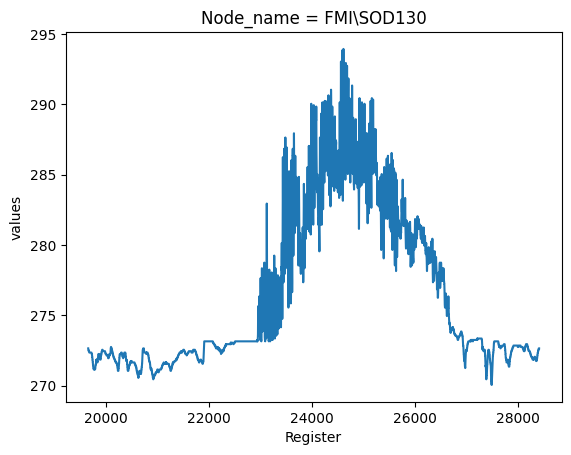

In [8]:
ISMN_dataset.where(ISMN_dataset["2017_mask"] == True).where(ISMN_dataset["quality_flag"] == 1)['values'][node,:].plot()

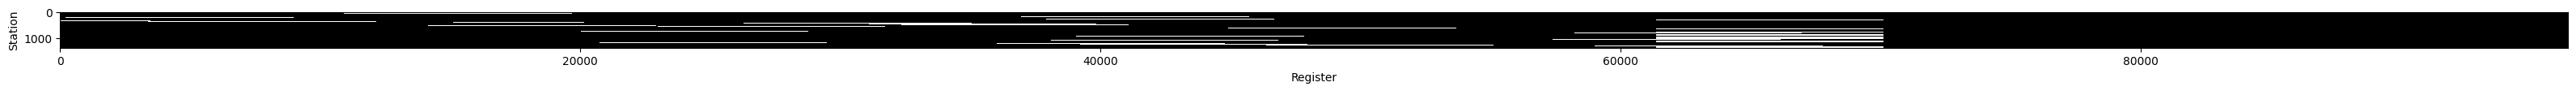

In [10]:
# TODO: Match the dates in each register and create a proper time dimention (Node_id, Timestam/datetime) instead of the N° of observation WHICH IS NOT CONSISTENT BETWEEN STATIONS:

plt.figure(figsize=(40,2))
plt.imshow(ISMN_dataset["2017_mask"], cmap='gray', interpolation='nearest')
plt.xlabel('Register')
plt.ylabel('Station')
plt.show()